In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score  
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


pdata = pd.read_csv("../Data/preprocessed_final.csv")
# pdata = pdata.drop(["Unnamed: 0.1"], axis=1)
# pdata = pdata.drop(["Unnamed: 0"], axis=1)
pdata['Conditie'] = pdata['Conditie'].map({'norm': 0,  'bril': 1})
pdata

,Conditie,SubjectID,Height,Weight,Age,BMI,Alcohol,Alcohol_Class,Balance_MeanVelocity,GaitVelocity,MovementVelocity,std_SegmentData,mad_SegmentData,mean_StepLength,GaitTime
0,0,6,177,70.0,20,22.343516,0.00,0,4.725911,1.175792,1.187491,0.051247,0.040761,0.664377,2.191667
1,1,6,177,70.0,20,22.343516,0.00,0,10.095526,0.899814,0.904473,0.040890,0.032495,0.543385,2.741667
2,0,9,195,86.0,23,22.616700,0.00,0,5.022392,1.114992,1.121095,0.022745,0.019538,0.700817,2.241667
3,1,9,195,86.0,23,22.616700,0.00,0,4.220501,0.895401,0.908965,0.042159,0.033549,0.497828,2.825000
4,0,10,165,65.0,28,23.875115,0.00,0,4.189830,0.822858,0.855915,0.106283,0.095379,0.516998,3.133333
5,1,10,165,65.0,28,23.875115,0.00,0,4.302662,0.878300,0.896931,0.061240,0.053097,0.522667,2.833333
6,0,11,179,68.0,25,21.222808,0.00,0,4.336345,0.989439,1.000792,0.021762,0.018467,0.586470,2.508333
7,1,11,179,68.0,25,21.222808,0.00,0,3.650951,0.873232,0.900053,0.103909,0.088957,0.445404,3.383333
8,0,13,168,70.0,18,24.801587,0.00,0,4.825908,1.049215,1.053802,0.025560,0.020575,0.639974,2.383333
9,1,13,168,70.0,18,24.801587,0.00,0,7.224777,0.955712,0.960144,0.049625,0.040664,0.591725,2.750000


In [35]:
#Splits data into training and validation according to specified ratio
def validation_split(data, ratio):
    sidlist = data['SubjectID'].unique()
    gdata = [data[data['SubjectID']==sid] for sid in sidlist]
    np.random.shuffle(gdata)
    N = len(gdata)
    training = gdata[:int(ratio*N)]
    validation = gdata[(int(ratio*N)):]
    return training,validation

# Converts the arrays in a list to one flattend dataframe
def flatten(data, variable_list):
    return pd.DataFrame(np.vstack(data), columns=variable_list)

def get_split_data(originaldata, variable_list, ratio):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    Xtrain = training.drop(['Conditie', 'SubjectID'], axis=1)
    Ytrain = training['Conditie']
    Xtrain = Xtrain.astype(float)
    Ytrain = Ytrain.astype(int)
    
    Xval = validation.drop(['Conditie', 'SubjectID'], axis=1)
    Yval = validation['Conditie']
    Xval = Xval.astype(float)
    Yval = Yval.astype(int)
    return Xtrain, Xval, Ytrain, Yval

collist =  ['SubjectID', 'Conditie', 'mean_StepLength', 'Age']
Xtrain, Xval, Ytrain, Yval = get_split_data(pdata, collist , 0.7)
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(Xtrain)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(Xtrain)
X_test = scaler.transform(Xval)

# Make an instance of the Model
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [36]:
rf = RandomForestClassifier()

rf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
max_depth=2, max_features='auto', max_leaf_nodes=None,
min_impurity_split=1e-07, min_samples_leaf=1,
min_samples_split=2, min_weight_fraction_leaf=0.0,
n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
verbose=0, warm_start=False)

y_pred = rf.predict(Xval)
accuracy_score(Yval, y_pred)

0.81914893617021278

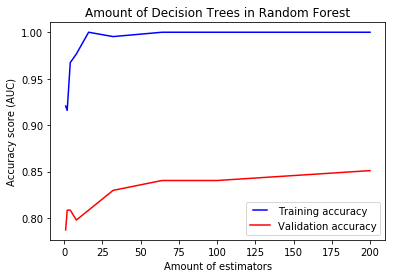

In [37]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

train_results = []
val_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(Xtrain, Ytrain)

   train_pred = rf.predict(Xtrain)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(Ytrain, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict(Xval)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(Yval, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   val_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, 'b', label="Training accuracy")
line2, = plt.plot(n_estimators, val_results, 'r', label="Validation accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy score (AUC)')
plt.xlabel('Amount of estimators')
plt.title("Amount of Decision Trees in Random Forest")
plt.show()

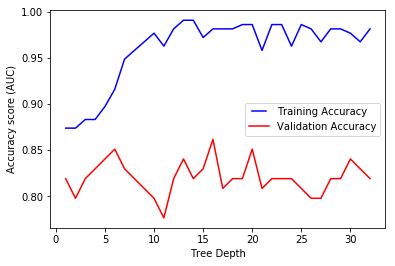

In [38]:
max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
val_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(Xtrain, Ytrain)

   train_pred = rf.predict(Xtrain)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(Ytrain, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict(Xval)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(Yval, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   val_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label="Training Accuracy")
line2, = plt.plot(max_depths, val_results, 'r', label="Validation Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy score (AUC)')
plt.xlabel('Tree Depth')
# plt.title("Tree Depths")
plt.show()

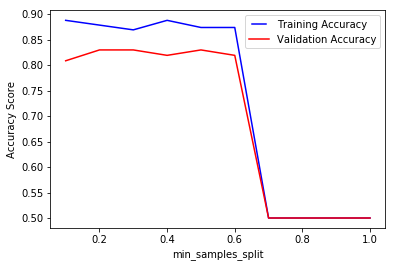

In [39]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(Xtrain, Ytrain)

   train_pred = rf.predict(Xtrain)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(Ytrain, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict(Xval)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(Yval, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_splits, train_results, 'b', label="Training Accuracy")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Validation Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy Score')
plt.xlabel('min_samples_split')
plt.show()

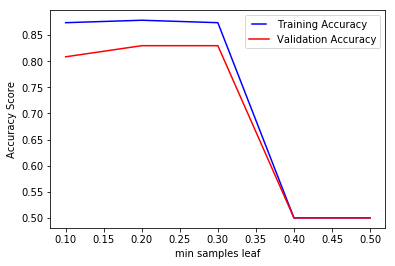

0.5

In [40]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
   rf.fit(Xtrain, Ytrain)

   train_pred = rf.predict(Xtrain)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(Ytrain, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict(Xval)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(Yval, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Training Accuracy")
line2, = plt.plot(min_samples_leafs, test_results,  'r', label="Validation Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy Score')
plt.xlabel('min samples leaf')
plt.show()

max(min_samples_leafs)

In [8]:
rf = RandomForestClassifier()

rf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
max_depth=5, max_features='auto', max_leaf_nodes=None,
min_impurity_split=1e-07, min_samples_leaf=0.2,
min_samples_split=0.1, min_weight_fraction_leaf=0.0,
n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
verbose=0, warm_start=False)

y_pred = rf.predict(Xval)
accuracy_score(Yval, y_pred)

0.75531914893617025

In [44]:

def make_decisions(originaldata, variable_list):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Conditie', 'SubjectID'], axis=1)
    y_train = training['Conditie']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Conditie', 'SubjectID'], axis=1)
    y_test = validation['Conditie']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    
    scaler = StandardScaler()

    # Fit on training set only.
    scaler.fit(X_train)

    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Make an instance of the Model
    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
    
    rf = RandomForestClassifier()

    rf.fit(X_train, y_train)

    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
    max_depth=5, max_features='auto', max_leaf_nodes=None,
    min_impurity_split=1e-07, min_samples_leaf=0.2,
    min_samples_split=0.1, min_weight_fraction_leaf=0.0,
    n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
    verbose=0, warm_start=False)

    y_pred = rf.predict(X_test)
    return accuracy_score(y_test, y_pred) * 100
make_decisions(pdata, collist)

86.170212765957444

In [45]:
print('mad_SegmentData, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie','mean_StepLength', 'mad_SegmentData']) for i in range(100)]), 2),'%')
print('mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%')
print('GaitTime, mean_StepLength, mad_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'mad_SegmentData']) for i in range(100)]), 2),'%')
print('std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'GaitTime', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'Age']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'Height']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'Age']) for i in range(100)]), 2),'%.')
print('GaitTime, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mad_SegmentData', 'Height']) for i in range(100)]), 2),'%.')
print('mad_SegmentData, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mad_SegmentData', 'Age']) for i in range(100)]), 2),'%.')


mad_SegmentData, mean_StepLength: 82.86 %
mean_StepLength, std_SegmentData: 82.68 %
GaitTime, mean_StepLength, mad_SegmentData: 83.38 %
std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength: 83.39 %.
GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData: 81.89 %.
GaitTime, mean_StepLength, Height: 85.46 %.
GaitTime, mean_StepLength, Age: 82.86 %.
mean_StepLength, Height: 82.07 %.
mean_StepLength, Age: 82.77 %.
GaitTime, Height: 79.43 %.
std_SegmentData, Height: 65.59 %.
mad_SegmentData, Age: 68.1 %.


BMV, Velocity: 0.551285517922

BMV, mean_StepLength: 0.531920260705

BMV, Age: 0.51308474837

BMV, mad: 0.549330382379

BMV, mad, Velocity: 0.549692351408

